In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
config = {
    'BATCH_SIZE':32,
    'IMAGE_SIZE': (224, 224),
    'SEED':42,
    'LEARNING_RATE':0.003,
    'EPOCHS':15
}

In [4]:
data_dir = '/content/drive/MyDrive/Doing_lab/food-data'

# apply augmentation 
train_image_gen = ImageDataGenerator(validation_split=0.2,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                            
validation_image_gen = ImageDataGenerator(validation_split=0.2)

train_generator = train_image_gen.flow_from_directory(
    data_dir,
    shuffle=True,
    seed=config['SEED'],
    target_size=config['IMAGE_SIZE'],
    batch_size=config['BATCH_SIZE'],
    class_mode='sparse',
    subset='training')

validation_generator = validation_image_gen.flow_from_directory(
    data_dir, 
    shuffle=False,
    seed=config['SEED'],
    target_size=config['IMAGE_SIZE'],
    batch_size=config['BATCH_SIZE'],
    class_mode='sparse',
    subset='validation')

Found 4419 images belonging to 55 classes.
Found 1103 images belonging to 55 classes.


In [5]:
from tensorflow.keras.applications import EfficientNetB0

# 클래스 개수
num_classes = train_generator.num_classes

# 모델 생성 함수
# 사전학습 모델을 불러와 마지막 레이어를 제외하고 전부 frozen

def create_model(input_shape, num_classes):
  base_model = EfficientNetB0(include_top=False, weights='imagenet')
  base_model.trainable = False
  
  inputs = Input(shape=input_shape)
  x = base_model(inputs, training=False)

  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)
  opt = Adam(learning_rate=config['LEARNING_RATE'])

  model.compile(
      optimizer=opt,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

model = create_model(config['IMAGE_SIZE'] + (3,), num_classes)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 55)                70455     
Total params: 4,120,026
Trainable params: 70,455
Non-trainable params: 4,049,571
_________________________________________________________________


In [6]:
checkpoint_path = '/content/drive/MyDrive/Doing_lab/checkpoint/CASE3_EfficientNetB0.h5'

mc = ModelCheckpoint(filepath=checkpoint_path,
                     save_weight_only=True,
                     save_best_only=True,
                     monitor='val_loss',
                     verbose=1)

es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1)

hist = model.fit(train_generator,
                 validation_data=validation_generator,
                 epochs=config['EPOCHS'],
                 callbacks=[mc, es])

Epoch 1/15
139/139 [==============================] - 1812s 13s/step - loss: 2.9814 - accuracy: 0.2843 - val_loss: 1.5221 - val_accuracy: 0.5884

Epoch 00001: val_loss improved from inf to 1.52209, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE3_EfficientNetB0.h5
Epoch 2/15
139/139 [==============================] - 77s 553ms/step - loss: 1.3924 - accuracy: 0.6409 - val_loss: 1.3425 - val_accuracy: 0.6374

Epoch 00002: val_loss improved from 1.52209 to 1.34249, saving model to /content/drive/MyDrive/Doing_lab/checkpoint/CASE3_EfficientNetB0.h5
Epoch 3/15
139/139 [==============================] - 76s 545ms/step - loss: 1.1193 - accuracy: 0.7038 - val_loss: 1.3484 - val_accuracy: 0.6310

Epoch 00003: val_loss did not improve from 1.34249
Epoch 4/15
139/139 [==============================] - 76s 546ms/step - loss: 0.9813 - accuracy: 0.7214 - val_loss: 1.2877 - val_accuracy: 0.6355

Epoch 00004: val_loss improved from 1.34249 to 1.28769, saving model to /content/drive/My

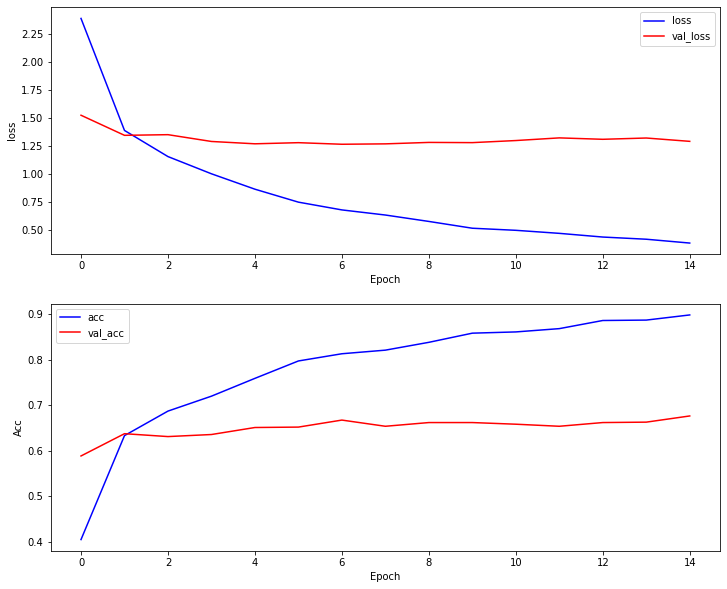

In [7]:
# 그래프
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# loss, val_loss
ax[0].set_ylabel("loss")
ax[0].set_xlabel("Epoch")
ax[0].plot(hist.history['loss'], 'b-', label = 'loss')
ax[0].plot(hist.history['val_loss'], 'r-', label = 'val_loss')
ax[0].legend()

# acc, val_acc
ax[1].set_ylabel("Acc")
ax[1].set_xlabel("Epoch")
ax[1].plot(hist.history['accuracy'], 'b-', label = 'acc')
ax[1].plot(hist.history['val_accuracy'], 'r-', label = 'val_acc')
ax[1].legend()

plt.show()

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

validation_generator.reset()

# 예측값 
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=-1)

# 실제값
class_names = [key for key, value in train_generator.class_indices.items()]
y_real = validation_generator.classes[validation_generator.index_array]

# # confusion matrix
cm = confusion_matrix(y_real, y_pred)

# accuracy_score, recall_score, precision_score
print(classification_report(y_real, y_pred, target_names=class_names))

print("Acc :", accuracy_score(y_real, y_pred))
print("Recall :", recall_score(y_real, y_pred, average='macro'))
print("Precision :", precision_score(y_real, y_pred, average='macro'))

                         precision    recall  f1-score   support

              apple_pie       0.47      0.40      0.43        20
         baby_back_ribs       0.80      0.60      0.69        20
                baklava       0.59      0.50      0.54        20
         beef_carpaccio       0.75      0.45      0.56        20
           beef_tartare       0.44      0.35      0.39        20
             beet_salad       0.62      0.40      0.48        20
               beignets       0.93      0.65      0.76        20
               bibimbap       0.95      0.90      0.92        20
          bread_pudding       0.40      0.30      0.34        20
      breakfast_burrito       0.57      0.80      0.67        20
             bruschetta       0.41      0.65      0.50        20
           caesar_salad       0.62      0.80      0.70        20
                cannoli       0.62      0.80      0.70        20
          caprese_salad       0.61      0.70      0.65        20
            carrot_cake 

In [11]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 8  0  1 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 1  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 24  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0 22]]


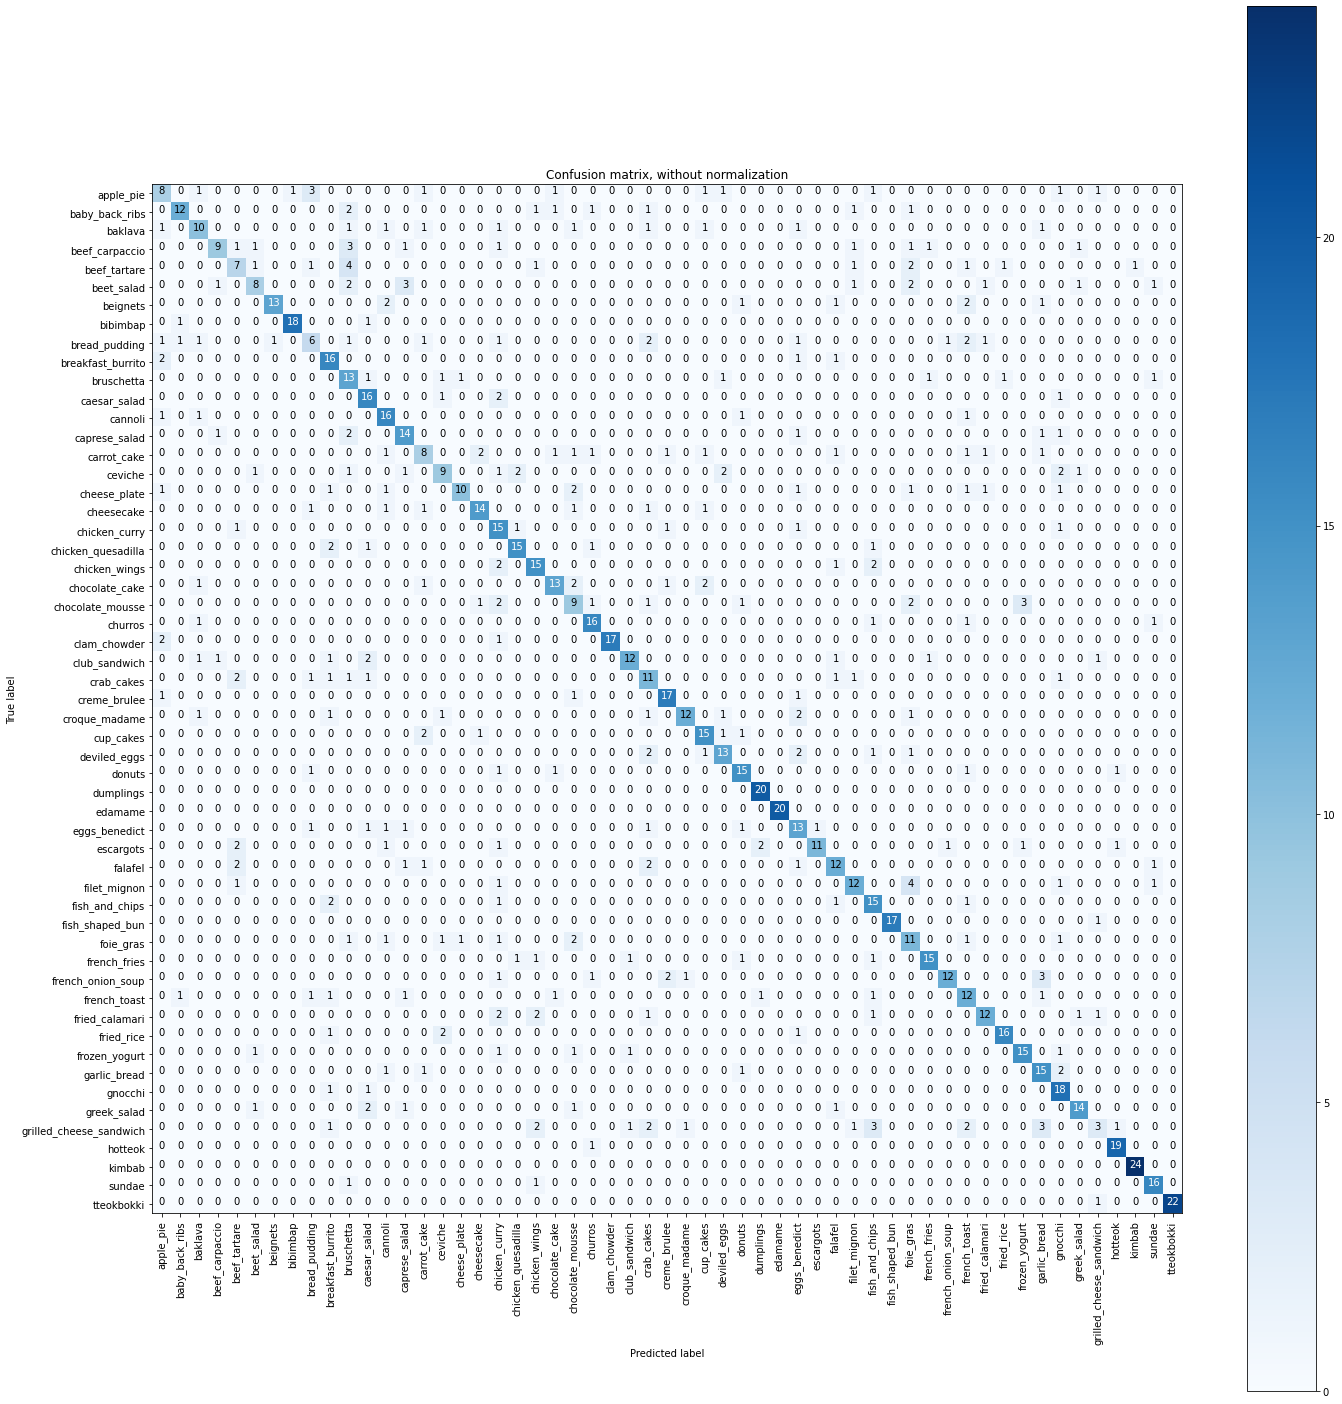

In [12]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')